# Find Best Wine for You

In [ ]:
#needed instalation
!pip install --upgrade torch
!pip install transformers
!pip install -U sentence-transformers
!pip install nmslib
!pip install -U gensim
!pip install git+https://github.com/jbesomi/texthero.git

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections.abc import Mapping
import texthero as hero
from texthero import preprocessing
from sentence_transformers import SentenceTransformer
import nmslib

/usr/local/lib/python3.10/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (3.5.0) requires spaCy v3.5 and is incompatible with the current spaCy version (2.3.9). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#collect and read the data
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0SV2EN/winemag-data-130k-v2.csv")
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
df.shape

(129971, 14)

## Data processing

Let's start by cleaning up our data first. Below, we drop any duplicated entries (based on the "description" column) contained in the dataset.

In [5]:
df = df.drop_duplicates('description')
df.shape

(119955, 14)

In [6]:
#check if there any missing values
df.isnull().sum()

Unnamed: 0                   0
country                     59
description                  0
designation              34532
points                       0
price                     8388
province                    59
region_1                 19558
region_2                 73195
taster_name              24912
taster_twitter_handle    29441
title                        0
variety                      1
winery                       0
dtype: int64

In [7]:
#lets drop the null prices
df = df.dropna(subset=['price'])
df.shape

(111567, 14)

Now, we can play with the dataset to extract some interesting information about our wines. We set the index to "country" column, so it is easier to filter our data to a specific country.

In [8]:
country = df.set_index("country")

In [9]:
#Filter only Italian wines
Italy = country.loc[["Italy"]]
Italy

,Unnamed: 0,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
country,,,,,,,,,,,,,
Italy,6,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
Italy,22,Delicate aromas recall white flower and citrus...,Ficiligno,87,19.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Baglio di Pianetto 2007 Ficiligno White (Sicilia),White Blend,Baglio di Pianetto
Italy,24,"Aromas of prune, blackcurrant, toast and oak c...",Aynat,87,35.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Canicattì 2009 Aynat Nero d'Avola (Sicilia),Nero d'Avola,Canicattì
Italy,26,Pretty aromas of yellow flower and stone fruit...,Dalila,87,13.0,Sicily & Sardinia,Terre Siciliane,NaN,Kerin O’Keefe,@kerinokeefe,Stemmari 2013 Dalila White (Terre Siciliane),White Blend,Stemmari
Italy,27,"Aromas recall ripe dark berry, toast and a whi...",NaN,87,10.0,Sicily & Sardinia,Terre Siciliane,NaN,Kerin O’Keefe,@kerinokeefe,Stemmari 2013 Nero d'Avola (Terre Siciliane),Nero d'Avola,Stemmari
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy,129929,"This luminous sparkler has a sweet, fruit-forw...",NaN,91,38.0,Veneto,Prosecco Superiore di Cartizze,NaN,NaN,NaN,Col Vetoraz Spumanti NV Prosecco Superiore di...,Prosecco,Col Vetoraz Spumanti
Italy,129943,"A blend of Nero d'Avola and Syrah, this convey...",Adènzia,90,29.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Baglio del Cristo di Campobello 2012 Adènzia R...,Red Blend,Baglio del Cristo di Campobello
Italy,129947,"A blend of 65% Cabernet Sauvignon, 30% Merlot ...",Symposio,90,20.0,Sicily & Sardinia,Terre Siciliane,NaN,Kerin O’Keefe,@kerinokeefe,Feudo Principi di Butera 2012 Symposio Red (Te...,Red Blend,Feudo Principi di Butera


In [11]:
#or US and Spanish wines
us_n_spain = df[(df["country"] == "US") | (df["country"] == "Spain")]
us_n_spain.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature


### Now lets see whitch countries contai the biggest amount of wine reviews

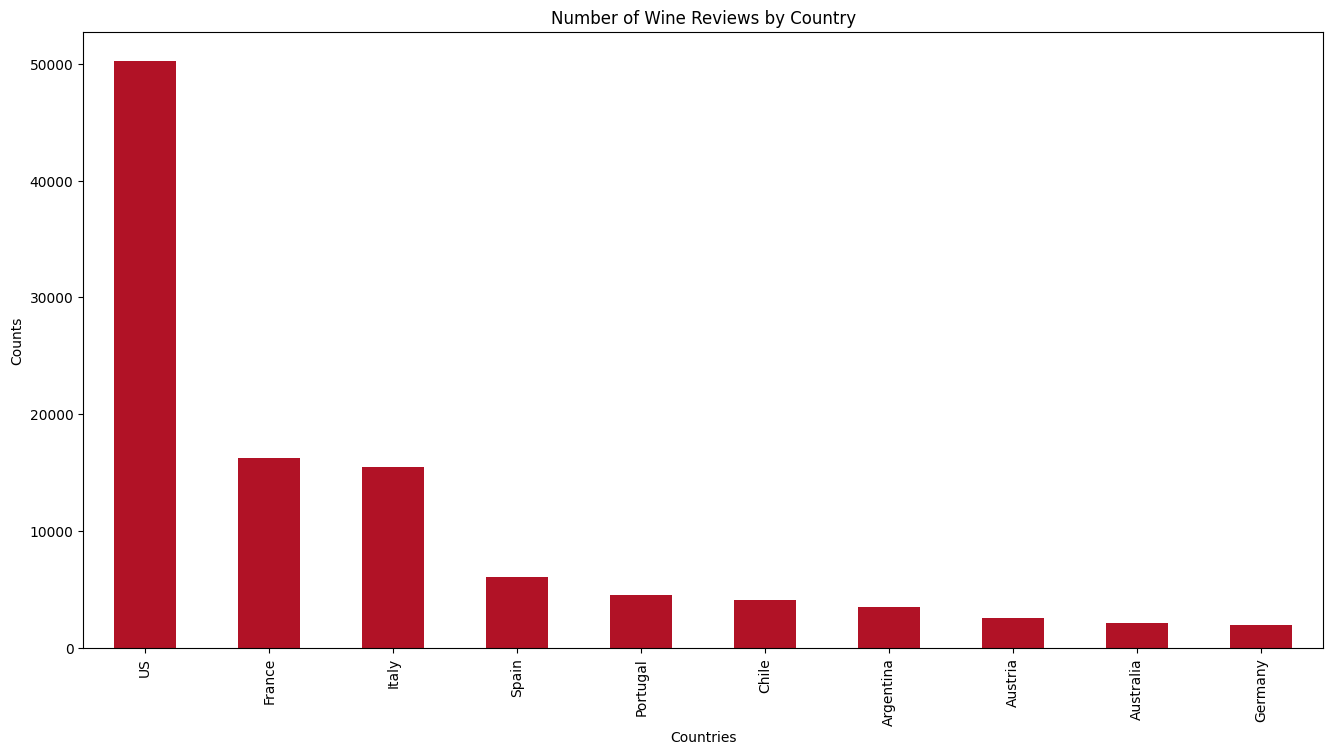

In [15]:
df.country.value_counts().iloc[:10].plot(kind = 'bar', figsize = (16, 8), color = "#b11226")
plt.title('Number of Wine Reviews by Country')
plt.ylabel('Counts')
plt.xlabel('Countries')
plt.show()

### Or vizualize the same plot but only for top 10 varietes of wine

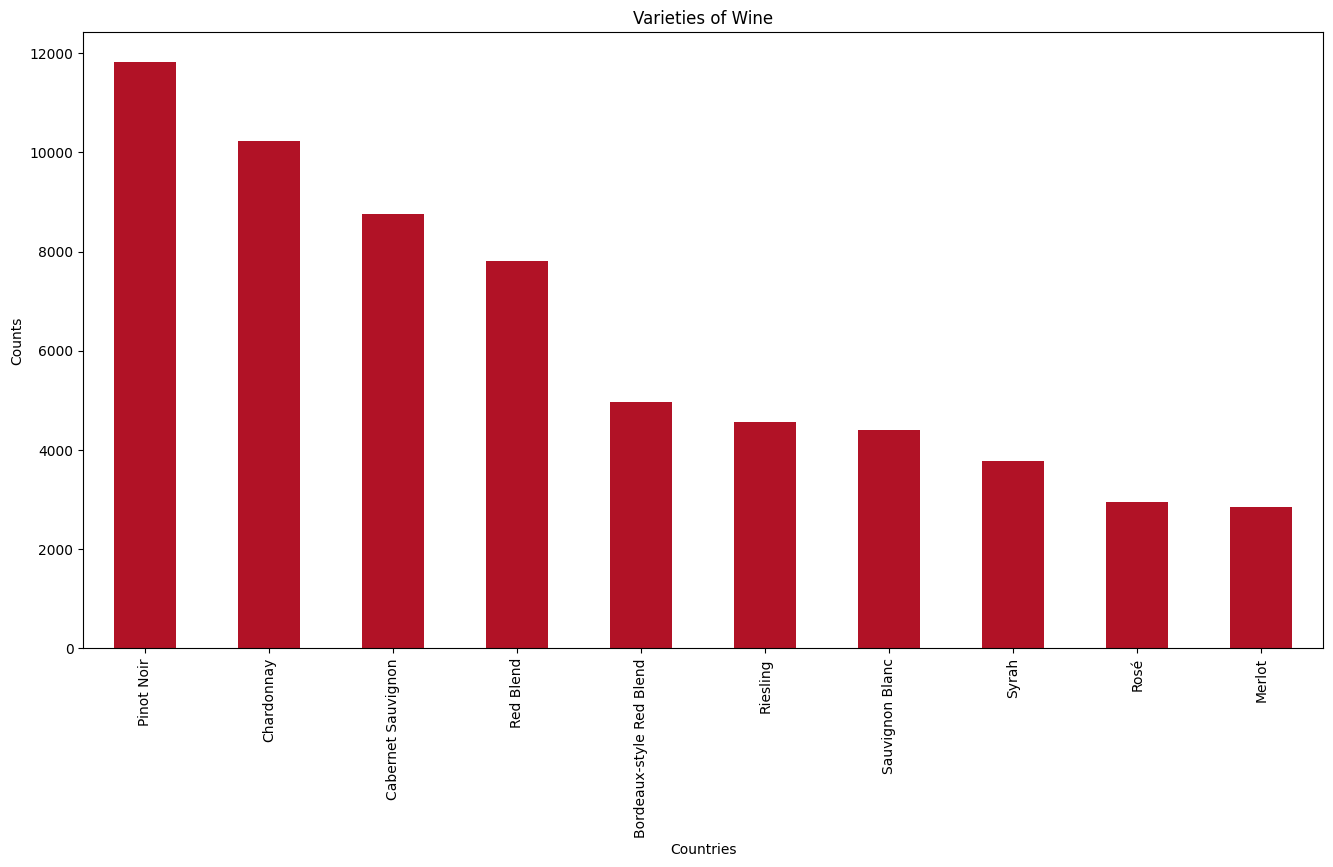

In [17]:
df.variety.value_counts().iloc[:10].plot(kind = 'bar', figsize = (16, 8),  color = "#b11226")
plt.title('Varieties of Wine')
plt.ylabel('Counts')
plt.xlabel('Countries')
plt.show()

Now, let's group some data to show the most expensive varieties of wine.

[Text(0.5, 1.0, 'The Most Expensive Varieties')]

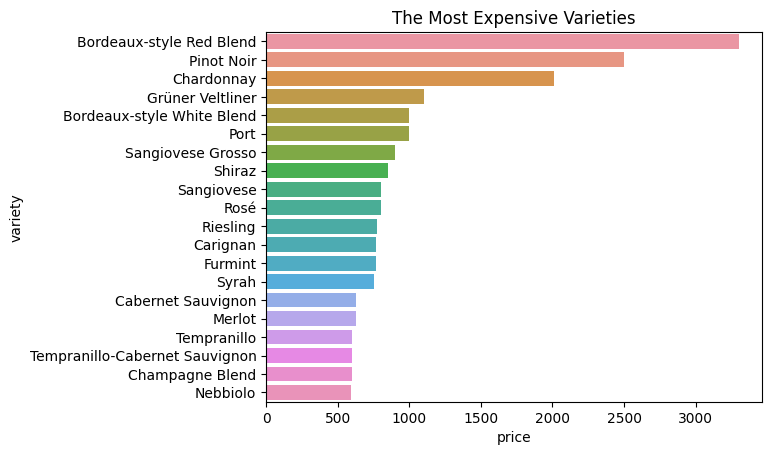

In [18]:
exp_wines = df.groupby(['variety'])['price'].max().sort_values(ascending = False).to_frame()[:20]

sns.barplot(x = exp_wines['price'], y = exp_wines.index).set(title='The Most Expensive Varieties')

#### or group some data to show the highest quality varieties of wine

<Axes: xlabel='points', ylabel='variety'>

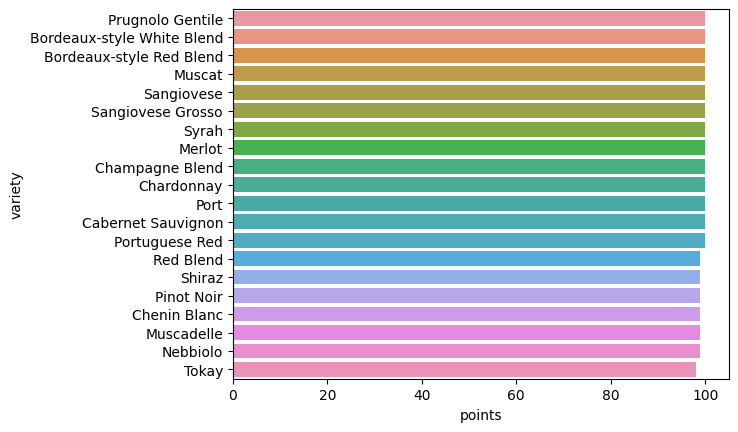

In [20]:
high_qual = df.groupby(['variety'])['points'].max().sort_values(ascending = False).to_frame()[:20]
sns.barplot(x = high_qual['points'], y = high_qual.index)

#### Now lets find somw good quality wines under $25. Points higher than '89' as an indicator of good wine

In [21]:
good_under25 = df[(df["price"] < 25) & (df["points"] >= 89)]
good_under25

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
127,127,France,Attractive mid-gold color with intense aromas ...,Alsace One,91,13.0,Alsace,Alsace,NaN,NaN,NaN,Pierre Sparr 2008 Alsace One White (Alsace),White Blend,Pierre Sparr
128,128,France,"Compelling minerality on the nose, Refined and...",NaN,91,17.0,Alsace,Alsace,NaN,NaN,NaN,Kuentz-Bas 2008 Pinot Blanc (Alsace),Pinot Blanc,Kuentz-Bas
131,131,France,Attractive mid-gold color. Compelling layers o...,Gentil,91,20.0,Alsace,Alsace,NaN,NaN,NaN,Dopff & Irion 2008 Gentil White (Alsace),Alsace white blend,Dopff & Irion
138,138,France,Mid-gold color. Very mineral driven with subtl...,Crustacés,90,10.0,Alsace,Alsace,NaN,NaN,NaN,Dopff & Irion 2008 Crustacés White (Alsace),Alsace white blend,Dopff & Irion
142,142,US,"A beautiful wine, sleek, crisp and ultra-dry, ...",NaN,90,17.0,California,Santa Lucia Highlands,Central Coast,NaN,NaN,Banyan 2007 Riesling (Santa Lucia Highlands),Riesling,Banyan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129954,129954,New Zealand,One of the more characterful Pinot Gris for th...,Single Estate,90,15.0,Marlborough,NaN,NaN,Joe Czerwinski,@JoeCz,Ara 2013 Single Estate Pinot Gris (Marlborough),Pinot Gris,Ara
129956,129956,New Zealand,"The blend is 44% Merlot, 33% Cabernet Sauvigno...",Gimblett Gravels Merlot-Cabernet Sauvignon-Malbec,90,19.0,Hawke's Bay,NaN,NaN,Joe Czerwinski,@JoeCz,Esk Valley 2011 Gimblett Gravels Merlot-Cabern...,Bordeaux-style Red Blend,Esk Valley
129957,129957,Spain,Lightly baked berry aromas vie for attention w...,Crianza,90,17.0,Northern Spain,Rioja,NaN,Michael Schachner,@wineschach,Viñedos Real Rubio 2010 Crianza (Rioja),Tempranillo Blend,Viñedos Real Rubio
129963,129963,Israel,"A bouquet of black cherry, tart cranberry and ...",Oak Aged,90,20.0,Galilee,NaN,NaN,Mike DeSimone,@worldwineguys,Dalton 2012 Oak Aged Cabernet Sauvignon (Galilee),Cabernet Sauvignon,Dalton


#### Now we creating plot showing the lowest priced varieties of wines with higher than '89' score

<Axes: xlabel='price', ylabel='variety'>

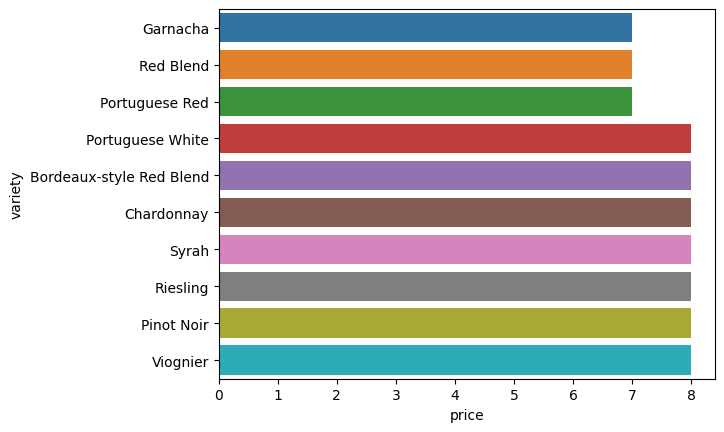

In [22]:
s = good_under25.groupby(['variety'])['price'].min().sort_values(ascending = True).to_frame()[:10]
sns.barplot(x = s['price'], y = s.index)

## Text pre-processing using HuggingFace

A machine can only work with numbers, no matter what data we provide to it: video, audio, image, or text. That is why, representing text as numbers or embedding text, is a number one step that we must do before any text analysis.

In [23]:
#First, we will take a subset of our data for quicker processing time.
subset = df.sample(frac=0.01)
subset.reset_index(inplace = True,drop = True)
subset.shape

(1116, 14)

In [24]:
#load the distilbert
model = SentenceTransformer('distilbert-base-uncased')

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
#generate the embeddings of the wine reviews
embeddings = model.encode(subset['description'], convert_to_tensor=True)
embeddings

tensor([[-0.4519, -0.0662,  0.1655,  ..., -0.1248,  0.0170,  0.0247],
        [-0.1349,  0.0513,  0.3102,  ..., -0.0816, -0.0412, -0.0547],
        [-0.2521,  0.0481,  0.1510,  ..., -0.1358,  0.1686, -0.1601],
        ...,
        [-0.2878, -0.0939,  0.2514,  ..., -0.1006,  0.1018, -0.0909],
        [-0.1466,  0.0084,  0.1792,  ...,  0.0209, -0.0896, -0.0842],
        [-0.3443, -0.1018,  0.2196,  ..., -0.2685, -0.0582, -0.1278]])

In [26]:
print(len(embeddings[0]))

768


In [27]:
#adding embeddings to dataframe
subset['vectors'] = np.array(embeddings).tolist()

subset.head(1)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vectors
0,88778,Australia,"Predominantly Grenache, with smaller amounts o...",Artisan Wines Classic,86,10.0,Australia Other,South Eastern Australia,NaN,Joe Czerwinski,@JoeCz,Marquee 2006 Artisan Wines Classic G-S-M (Sout...,G-S-M,Marquee,"[-0.45186537504196167, -0.06618455797433853, 0..."


## Creating a Search Index

When we perform our search based on the description of wine, we need to be able to find the closest vectors to our search vector. We start by creating an index for the data points. For this, we can use the lightweight and efficient Non-Metric Space Library (NMSLIB). There 3 steps associated with this process:

### 1. Initialize a new index passing 'hnsw' as the method and 'cosinesimil' as the space.

In [28]:
model_index = nmslib.init(method='hnsw', space='cosinesimil')

### 2. Add the embeddings to the index using `addDataPointBatch()` method.

In [29]:
model_index.addDataPointBatch(embeddings)

1116

### 3. Create the index with the data points using `createIndex method()`.



In [30]:
#Postprocessing is set to 2 means the maximum level of postprocessing.
model_index.createIndex({'post': 2})

## Creating a Search Function

The idea is that it searches for the best bottle of wine based on an index of similarity between reviews.

In [31]:
def find_best_wine(data, q_input):
    """
    input: dataframe with embedding vectors,
           q_input - users taste or description;
    output: dataframe with wine data and distance;
    """
    if data is not None and q_input is not None:
        subset = data.copy()
        query = model.encode([q_input], convert_to_tensor=True)
        ids, distances = model_index.knnQuery(query, k=20)

    best_fits = []
    for i, j in zip(ids, distances):

          best_fits.append({'country':subset.country.values[i]
                        , 'winery' : subset.winery.values[i]
                        , 'title' : subset.title.values[i]
                        , 'variety': subset.variety.values[i]
                        , 'description': subset.description.values[i]
                        , 'price': subset.price.values[i]
                        , 'points': subset.points.values[i]
                        , 'distance': j
                       })
    return pd.DataFrame(best_fits)

In [38]:
#test our function with description
most_similar=find_best_wine(subset, "dry and fruity")
most_similar.head(3)

,country,winery,title,variety,description,price,points,distance
0,US,Jekel,Jekel 2011 Pinot Noir (Santa Barbara County),Pinot Noir,"Thin and reedy, with cherry tea, cola and gree...",18.0,81,0.195115
1,US,Lake Chelan,Lake Chelan 2008 Rivers Bend Vineyard Syrah (C...,Syrah,"A very light Syrah, with pleasant watermelon a...",28.0,84,0.201796
2,US,Peter Paul Wines,Peter Paul Wines 2009 Mill Station Road Pinot ...,Pinot Noir,"A bit stemmy, also a little underripe, with so...",40.0,85,0.203510


In [39]:
#Let's print the descriptions together with their 'distance' parameters.
for i in range(0,3):
    print(most_similar['description'][i][0:-1])
    print("distance:",most_similar['distance'][i])

Thin and reedy, with cherry tea, cola and green herb, vegetal flavors. Drink up
distance: 0.19511515
A very light Syrah, with pleasant watermelon and raspberry fruit, that hangs in there until the fairly soft tannins take over
distance: 0.20179605
A bit stemmy, also a little underripe, with some minty, vegetal notes marring otherwise fine raspberries and cherries. Drink now
distance: 0.2035104


## We also can create Visual Explorer

In [ ]:
# subset['tsnemodel'] = hero.tsne(subset['vectors'])
# hero.scatterplot(subset, col='tsnemodel'
#                  , color='variety'
#                  , title="Wine Explorer"
#                  , hover_data = ['title','variety','price','description'])